In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
archivo = '/content/drive/My Drive/Social./Trabajo./InDataAnalitycs/datoSOI.csv'
df = pd.read_csv(archivo)

In [ ]:
df

,Year,Month,SOI,Six month mean
0,1876,1,10.80,NaN
1,1876,2,10.60,NaN
2,1876,3,-0.70,NaN
3,1876,4,7.90,NaN
4,1876,5,6.90,NaN
...,...,...,...,...
1725,2019,10,-5.19,-7.4
1726,2019,11,-9.45,-7.7
1727,2019,12,-6.72,-7.2
1728,2020,1,0.65,-6.1


In [ ]:
df['SOI']

0       10.80
1       10.60
2       -0.70
3        7.90
4        6.90
        ...  
1725    -5.19
1726    -9.45
1727    -6.72
1728     0.65
1729    -2.60
Name: SOI, Length: 1730, dtype: float64

In [ ]:
# Preprocesar los datos
# Agregar una columna "Date" que combine Year y Month para tener una fecha
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
# Seleccionar la columna "Date" como índice
df.set_index('Date', inplace=True)
# Normalizar los valores de SOI
soi_mean = df['SOI'].mean()
soi_std = df['SOI'].std()
df['SOI'] = (df['SOI'] - soi_mean) / soi_std


In [ ]:
df['SOI']

Date
1876-01-01    1.111027
1876-02-01    1.090810
1876-03-01   -0.051438
1876-04-01    0.817884
1876-05-01    0.716800
                ...   
2019-10-01   -0.505305
2019-11-01   -0.935923
2019-12-01   -0.659964
2020-01-01    0.085025
2020-02-01   -0.243498
Name: SOI, Length: 1730, dtype: float64

In [ ]:
 df['SOI'] * soi_std + soi_mean


Date
1876-01-01    10.80
1876-02-01    10.60
1876-03-01    -0.70
1876-04-01     7.90
1876-05-01     6.90
              ...  
2019-10-01    -5.19
2019-11-01    -9.45
2019-12-01    -6.72
2020-01-01     0.65
2020-02-01    -2.60
Name: SOI, Length: 1730, dtype: float64

In [ ]:
# Crear secuencias de datos de entrenamiento
sequence_length = 12  # Usar un año de datos para predecir el siguiente
sequences = []
for i in range(len(df) - sequence_length):
    sequence = df['SOI'].iloc[i:i + sequence_length].values
    target = df['SOI'].iloc[i + sequence_length]
    sequences.append((sequence, target))

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
test_data = sequences[train_size:]

In [ ]:
# Definir una clase de modelo RNN simple
class SOIModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SOIModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
# Crear el modelo
input_size = 1  # Solo se predice el valor SOI
hidden_size = 64
num_layers = 2
model = SOIModel(input_size, hidden_size, num_layers)


In [ ]:
# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    for sequence, target in train_data:
        sequence = np.reshape(sequence, (1, sequence_length, 1))
        sequence = Variable(torch.Tensor(sequence))
        target = Variable(torch.Tensor(np.array([target])))

        # Forward pass
        outputs = model(sequence)
        loss = criterion(outputs, target)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.5059
Epoch [20/100], Loss: 0.4941
Epoch [30/100], Loss: 0.4299
Epoch [40/100], Loss: 0.0339
Epoch [50/100], Loss: 0.0736
Epoch [60/100], Loss: 0.0092
Epoch [70/100], Loss: 0.1086
Epoch [80/100], Loss: 0.0735
Epoch [90/100], Loss: 0.0162
Epoch [100/100], Loss: 0.1215


In [ ]:
# Evaluar el modelo en el conjunto de prueba
model.eval()
test_losses = []
with torch.no_grad():
    for sequence, target in test_data:
        sequence = np.reshape(sequence, (1, sequence_length, 1))
        sequence = Variable(torch.Tensor(sequence))
        target = Variable(torch.Tensor(np.array([target])))

        outputs = model(sequence)
        loss = criterion(outputs, target)
        test_losses.append(loss.item())

average_test_loss = np.mean(test_losses)
print(f'Loss mean in the test set: {average_test_loss:.4f}')


Promedio de pérdida en el conjunto de prueba: 0.8487


In [ ]:
# Predecir los valores de SOI para los próximos 8 años
future_predictions = []
last_sequence = test_data[-1][0]
for i in range(8 * 12):
    sequence = np.reshape(last_sequence, (1, sequence_length, 1))
    sequence = Variable(torch.Tensor(sequence))
    prediction = model(sequence)
    future_predictions.append(prediction.item())
    last_sequence = np.append(last_sequence[1:], prediction.item())

In [ ]:
future_predictions

array([ 3.50296088, -5.83524558, -2.74728376,  0.91893604, -1.4463178 ,
        5.93126417,  3.35206846, -4.33569753, -3.55193226,  0.22329017,
        0.6464609 ,  1.15212027,  3.12136477, -2.64555353,  1.24783645,
        3.31867011, -2.92664826,  1.08821346,  1.59376212,  1.05687448,
        0.97691107,  3.4818076 , -0.39357842, -6.04560146, -1.62291902,
        4.09213647,  4.35537791,  1.03626132, -2.23924823,  1.16820266,
        8.38775268,  4.27330354,  0.20815756, -0.93004818,  5.11493874,
        1.42788082, 11.64470843,  4.06489471, -7.74249759, -5.78699942,
        8.04457525,  7.88004558, -1.10737586,  3.66651908, -2.82405389,
        8.42616516, -2.07373104, -3.29058773,  1.25130466, -2.22559329,
        3.40978802, -1.45035531, -9.32499595, -4.23358285,  1.83225014,
       -8.28085495, -3.41480386, -2.96386787, -2.48493476, -2.11563679,
       -2.23482287,  2.00323888, -5.84491415,  1.25331391,  0.21746173,
        0.27958424,  3.96661662,  1.87328482, -0.70311736, -2.06

In [ ]:
# Desnormalizar las predicciones
future_predictions = np.array(future_predictions) * soi_std + soi_mean


In [ ]:
# Imprimir las predicciones para los próximos 8 años
for i, prediction in enumerate(future_predictions):
    print(f'Year {i // 12 + 1}, Mes {i % 12 + 1}: Prediction SOI = {prediction:.4f}')

Año 1, Mes 1: Predicción SOI = -1.7226
Año 1, Mes 2: Predicción SOI = -8.7409
Año 1, Mes 3: Predicción SOI = 0.1916
Año 1, Mes 4: Predicción SOI = 0.1926
Año 1, Mes 5: Predicción SOI = 6.6436
Año 1, Mes 6: Predicción SOI = 13.3636
Año 1, Mes 7: Predicción SOI = 13.7488
Año 1, Mes 8: Predicción SOI = 9.2529
Año 1, Mes 9: Predicción SOI = 4.0416
Año 1, Mes 10: Predicción SOI = 8.4265
Año 1, Mes 11: Predicción SOI = 5.3113
Año 1, Mes 12: Predicción SOI = 3.8275
Año 2, Mes 1: Predicción SOI = 3.6925
Año 2, Mes 2: Predicción SOI = 7.7456
Año 2, Mes 3: Predicción SOI = 7.4812
Año 2, Mes 4: Predicción SOI = 9.5029
Año 2, Mes 5: Predicción SOI = 6.7498
Año 2, Mes 6: Predicción SOI = 7.4198
Año 2, Mes 7: Predicción SOI = 8.7504
Año 2, Mes 8: Predicción SOI = 2.9896
Año 2, Mes 9: Predicción SOI = 1.5300
Año 2, Mes 10: Predicción SOI = 3.6896
Año 2, Mes 11: Predicción SOI = 4.0963
Año 2, Mes 12: Predicción SOI = -4.2100
Año 3, Mes 1: Predicción SOI = -6.5065
Año 3, Mes 2: Predicción SOI = -5.1530

In [ ]:
from sklearn.metrics import mean_squared_error

# ...

# Evaluar el modelo en el conjunto de prueba
model.eval()
test_losses = []
true_values = []  # Almacena los valores reales
predicted_values = []  # Almacena las predicciones

with torch.no_grad():
    for sequence, target in test_data:
        sequence = np.reshape(sequence, (1, sequence_length, 1))
        sequence = Variable(torch.Tensor(sequence))
        target = Variable(torch.Tensor(np.array([target])))

        outputs = model(sequence)
        loss = criterion(outputs, target)
        test_losses.append(loss.item())

        # Almacenar valores reales y predicciones
        true_values.append(target.item())
        predicted_values.append(outputs.item())

average_test_loss = np.mean(test_losses)
print(f'Loss mean in the test set (MSE): {average_test_loss:.4f}')

# Calcular el MSE
mse = mean_squared_error(true_values, predicted_values)
print(f'Mean cuadratic error (MSE) in the test set: {mse:.4f}')


Promedio de pérdida en el conjunto de prueba (MSE): 0.8487
Error Cuadrático Medio (MSE) en el conjunto de prueba: 0.8487


In [ ]:
threshold = 2  # Umbral de tolerancia
correct_predictions = 0

for i in range(len(predicted_values)):
    if abs(predicted_values[i] - test_data[i][1]) <= threshold:
        correct_predictions += 1

accuracy = correct_predictions / len(predicted_values)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 97.38%


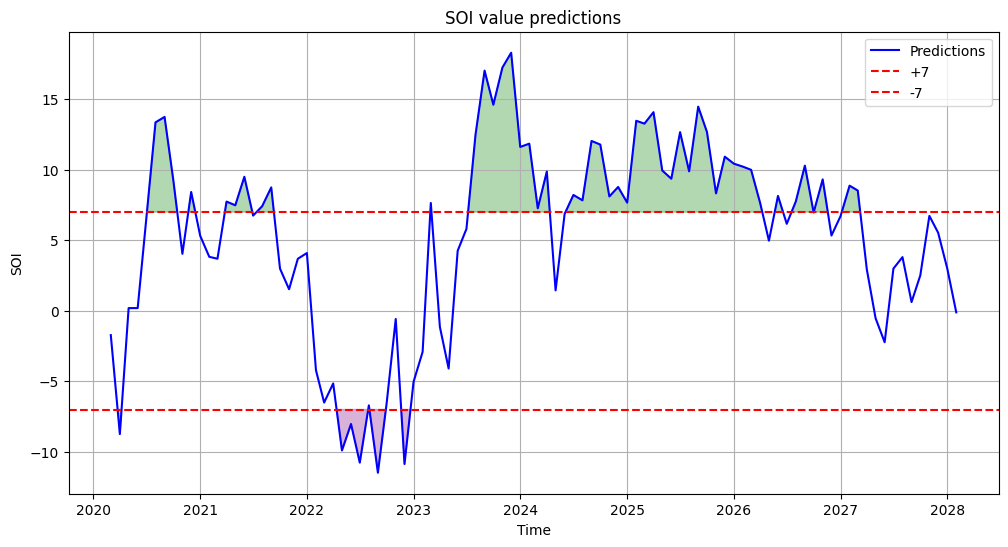

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un rango de fechas para los próximos 8 años (96 meses)
start_date = df.index[-1] + pd.DateOffset(months=1)
end_date = start_date + pd.DateOffset(months=95)
date_range = pd.date_range(start_date, end_date, freq='MS')

# Verificar que date_range y future_predictions tengan la misma longitud
if len(date_range) == len(future_predictions):
    # Crear un arreglo de colores basado en los valores de SOI
    colors = ['green' if x > 7 else 'purple' if x < -7 else 'blue' for x in future_predictions]

    # Graficar las predicciones
    plt.figure(figsize=(12, 6))
    plt.plot(date_range, future_predictions, label='Predictions', color='blue', linestyle='-')
    plt.axhline(y=7, color='red', linestyle='--', label='+7')
    plt.axhline(y=-7, color='red', linestyle='--', label='-7')
    plt.xlabel('Time')
    plt.ylabel('SOI')
    plt.title('SOI value predictions')
    plt.legend()
    plt.grid(True)

    # Rellenar áreas verdes y moradas según las condiciones
    plt.fill_between(date_range, future_predictions, 7, where=(future_predictions > 7), interpolate=True, color='green', alpha=0.3)
    plt.fill_between(date_range, future_predictions, -7, where=(future_predictions < -7), interpolate=True, color='purple', alpha=0.3)

    plt.show()
    plt.savefig("SOIpred.png")
else:
    print("The dimensions of date_range and future_predictions have no coincidence")




### ***A weird idea***

Do not try it, i left her because i want to prove it later

In [ ]:
# Crear secuencias de datos de entrenamiento y prueba
sequence_length = 12  # Usar un año de datos para predecir el siguiente
sequences = []
for i in range(len(df) - sequence_length):
    sequence = df['SOI'].iloc[i:i + sequence_length].values
    target = df['SOI'].iloc[i + sequence_length]
    sequences.append((sequence, target))

train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
test_data = sequences[train_size:]

# Crear un modelo de series temporales basado en LSTM
class TimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TimeSeriesModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Crear el modelo de series temporales
input_size = 1  # Solo se predice el valor SOI
hidden_size = 64
num_layers = 2
time_series_model = TimeSeriesModel(input_size, hidden_size, num_layers)

# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(time_series_model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    for sequence, target in train_data:
        sequence = np.reshape(sequence, (1, sequence_length, 1))
        sequence = Variable(torch.Tensor(sequence))
        target = Variable(torch.Tensor(np.array([target])))

        # Forward pass
        outputs = time_series_model(sequence)
        loss = criterion(outputs, target)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo en el conjunto de prueba (como en tu código anterior)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.3725
Epoch [20/100], Loss: 0.7632
Epoch [30/100], Loss: 0.2726
Epoch [40/100], Loss: 0.3342
Epoch [50/100], Loss: 0.1426
Epoch [60/100], Loss: 0.0121
Epoch [70/100], Loss: 0.0616
Epoch [80/100], Loss: 0.0217
Epoch [90/100], Loss: 0.0028
Epoch [100/100], Loss: 0.0072


In [ ]:
# Evaluar el modelo en el conjunto de prueba
time_series_model.eval()
test_losses = []
predicted_values = []

with torch.no_grad():
    for sequence, target in test_data:
        sequence = np.reshape(sequence, (1, sequence_length, 1))
        sequence = Variable(torch.Tensor(sequence))
        target = Variable(torch.Tensor(np.array([target])))

        outputs = time_series_model(sequence)
        loss = criterion(outputs, target)
        test_losses.append(loss.item())

        predicted_values.append(outputs.numpy()[0, 0])  # Añadir la predicción al resultado

average_test_loss = np.mean(test_losses)
print(f'Promedio de pérdida en el conjunto de prueba (MSE): {average_test_loss:.4f}')

# Desnormalizar las predicciones
predicted_values = (np.array(predicted_values) * soi_std) + soi_mean

# Imprimir las predicciones para el conjunto de prueba
for i, prediction in enumerate(predicted_values):
    print(f'Año {i + train_size // 12 + 1}, Mes {i + train_size % 12 + 1}: Predicción SOI = {prediction:.4f}')

Promedio de pérdida en el conjunto de prueba (MSE): 0.8238
Año 115, Mes 7: Predicción SOI = -7.6707
Año 116, Mes 8: Predicción SOI = 6.0266
Año 117, Mes 9: Predicción SOI = -3.0617
Año 118, Mes 10: Predicción SOI = -9.0013
Año 119, Mes 11: Predicción SOI = -8.7553
Año 120, Mes 12: Predicción SOI = -15.9826
Año 121, Mes 13: Predicción SOI = -11.4649
Año 122, Mes 14: Predicción SOI = -19.7980
Año 123, Mes 15: Predicción SOI = -15.5994
Año 124, Mes 16: Predicción SOI = -12.7355
Año 125, Mes 17: Predicción SOI = -8.3932
Año 126, Mes 18: Predicción SOI = -24.8483
Año 127, Mes 19: Predicción SOI = -10.8530
Año 128, Mes 20: Predicción SOI = -12.5324
Año 129, Mes 21: Predicción SOI = 0.4256
Año 130, Mes 22: Predicción SOI = -0.3233
Año 131, Mes 23: Predicción SOI = -6.1099
Año 132, Mes 24: Predicción SOI = -14.1652
Año 133, Mes 25: Predicción SOI = -6.7097
Año 134, Mes 26: Predicción SOI = -9.4296
Año 135, Mes 27: Predicción SOI = -9.3430
Año 136, Mes 28: Predicción SOI = -9.6262
Año 137, Mes 

In [ ]:
threshold = 0.1  # Umbral de tolerancia
correct_predictions = 0

for i in range(len(predicted_values)):
    if abs(predicted_values[i] - test_data[i][1]) <= threshold:
        correct_predictions += 1

accuracy = correct_predictions / len(predicted_values)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 0.87%


In [ ]:
accuracy

0.00872093023255814